# Test Best Models

Test notebook to generate the statistics of the different models found with AMS. First load the required libraries

In [1]:
import datetime
import logging
import sys
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
from keras.models import model_from_json

from sklearn.model_selection import KFold
from scipy import stats

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
sys.path.append('/media/controlslab/DATA/Projects')

import ann_framework.aux_functions as aux_functions

import automatic_model_selection
from automatic_model_selection import Configuration
from ann_encoding_rules import Layers
import fetch_to_keras
#from CMAPSAuxFunctions import TrainValTensorBoard

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression, SequenceTunableModelClassification

#Data handlers
from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.data_handlers.data_handler_MNIST import MNISTDataHandler
from ann_framework.data_handlers.data_handler_CIFAR10 import CIFAR10DataHandler

Using TensorFlow backend.


### Given a model, get the compiled model

In [2]:
def get_compiled_model(model, problem_type, optimizer_params=[]):
    """Obtain a keras compiled model"""
    
    #Shared parameters for the models
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    
    return model


def create_tunable_model(model_genotype, problem_type, input_shape, data_handler, model_number):
    
    K.clear_session()
    
    model = fetch_to_keras.decode_genotype(model_genotype, problem_type, input_shape, 1)
    
    model = get_compiled_model(model, problem_type, optimizer_params=[])
    
    if problem_type == 1:
        tModel = SequenceTunableModelRegression('ModelReg_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
    else:
        tModel = SequenceTunableModelClassification('ModelClass_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
        
    return tModel

### Load cmaps data handler

In [3]:
def cmaps_dhandler(data_scaler=None):

    #Selected as per CNN paper
    features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
    'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
    selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
    selected_features = list(features[i] for i in selected_indices-1)
    data_folder = '../CMAPSSData'

    window_size = 24
    window_stride = 1
    max_rul = 129

    dHandler_cmaps = CMAPSSDataHandler(data_folder, 1, selected_features,
                                       max_rul, window_size, window_stride, data_scaler=data_scaler)

    input_shape = (len(selected_features)*window_size, )

    return dHandler_cmaps

### Load models and evaluate model

In [4]:
def load_model(model_file, weights_file="", problem_type=1):
    
    p_type = ""
    
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Loaded model from disk") 
        
    #Load weights if specified
    if weights_file != "":
        # load weights into new model
        loaded_model.load_weights(weights_file)
        print("Loaded weights from disk") 
    else:
        print("Model needs training")
        
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        p_type = "regression"
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        p_type = "classification"
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    print("Created model for " + p_type + " with loss function " + lossFunction)

    return loaded_model
        
        

### Load each of the models and test them

In [5]:
best_model_folder = 'best_models'
"""
test_sets = {'cifar10':(CIFAR10DataHandler, None, 2), 
             'cmapss':(cmaps_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1), 
             'mnist':((MNISTDataHandler), None, 2)}
"""

test_sets = {'mnist':((MNISTDataHandler), None, 2)}
#alpha_folders = ['alpha0.6', 'alpha0.8', 'alpha1']
#alpha_folders = ['alpha0.5']
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#alpha_values = [0.2]

In [6]:
results = {}

k = 5  #For 10-fold cross validation

for dataset in test_sets.keys():
    for alphaValue in alpha_values:
        
        model_file_name = 'yulin/alpha{}/bestModel_global.json'.format(alphaValue)
        weights_file_name = 'yulin/alpha{}/bestModel_global.h5'.format(alphaValue)
        trainable_count = 0
        
        print("Testing for "+model_file_name)
        
        results_key = dataset + "_" +  str(alphaValue)
        
        evaluations_cv = np.zeros(k)
        evaluations_test = np.zeros(k)
        
        model_location = best_model_folder + '/' + dataset + '/' + model_file_name
        
        if weights_file_name != "":
            weights_location = best_model_folder + '/' + dataset + '/' + weights_file_name
        
        dhandler, data_scaler, problem_type = test_sets[dataset]

        #model = load_model(model_location, weights_location, problem_type)   
        
        data_handler = dhandler(data_scaler=data_scaler)
        data_handler.load_data(verbose = 1, unroll=True)
        data_handler.print_data()
        
        folds = list(KFold(n_splits=k, shuffle=True).split(data_handler.X_train))
        
        print('Validation on model:' + model_location)
        
        for j, (train_idx, val_idx) in enumerate(folds):

            print('\nExperiment on Fold ', j)
            
            K.clear_session()  #Clear the previous tensorflow graph 

            X_train_cv = data_handler.X_train[train_idx]
            y_train_cv = data_handler.y_train[train_idx]
            X_valid_cv = data_handler.X_train[val_idx]
            y_valid_cv = data_handler.y_train[val_idx]

            model = load_model(model_location, "", problem_type)
            model.summary()
            trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))

            model.fit(X_train_cv, y_train_cv, batch_size=512, epochs=100, verbose=1)

            evaluation_cv = model.evaluate(X_valid_cv, y_valid_cv)
            evaluation_test = model.evaluate(data_handler.X_test, data_handler.y_test)

            evaluations_cv[j] = evaluation_cv[1]
            evaluations_test[j] = evaluation_test[1]
            
        results[results_key] = (evaluations_cv, evaluations_test, trainable_count)
        

Testing for yulin/alpha0.2/bestModel_global.json
Loading data. Cross-Validation ratio 0
Printing shapes

Training data (X, y)
(60000, 784)
(60000, 10)
Testing data (X, y)
(10000, 784)
(10000, 10)
Printing first 5 elements

Training data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Testing data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Validation on model:best_models/mnist/yulin/alpha0.2/bestModel_global.json

Experiment on Fold  0
Loaded model from disk
Model needs training
Created mo

48000/48000 [==============================] - 0s 6us/step - loss: 0.0062 - acc: 0.9983
Epoch 64/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0053 - acc: 0.9986
Epoch 65/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0040 - acc: 0.9988
Epoch 66/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0025 - acc: 0.9993
Epoch 67/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0016 - acc: 0.9996
Epoch 68/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0029 - acc: 0.9991
Epoch 69/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0023 - acc: 0.9995
Epoch 70/100
48000/48000 [==============================] - 0s 7us/step - loss: 0.0070 - acc: 0.9976
Epoch 71/100
48000/48000 [==============================] - 0s 7us/step - loss: 0.0046 - acc: 0.9987
Epoch 72/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0026 - acc: 0.9992
Epo

48000/48000 [==============================] - 0s 6us/step - loss: 0.1870 - acc: 0.9461
Epoch 4/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.1520 - acc: 0.9558
Epoch 5/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.1274 - acc: 0.9618
Epoch 6/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.1094 - acc: 0.9679
Epoch 7/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0958 - acc: 0.9714
Epoch 8/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0836 - acc: 0.9753
Epoch 9/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0747 - acc: 0.9778
Epoch 10/100
48000/48000 [==============================] - 0s 7us/step - loss: 0.0654 - acc: 0.9804
Epoch 11/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0602 - acc: 0.9823
Epoch 12/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0527 - acc: 0.9842
Epoch 13/

48000/48000 [==============================] - 0s 6us/step - loss: 0.0034 - acc: 0.9992
Epoch 54/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0026 - acc: 0.9993
Epoch 55/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0041 - acc: 0.9988
Epoch 56/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0047 - acc: 0.9986
Epoch 57/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0037 - acc: 0.9990
Epoch 58/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0029 - acc: 0.9992
Epoch 59/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0035 - acc: 0.9991
Epoch 60/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0035 - acc: 0.9990
Epoch 61/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0040 - acc: 0.9988
Epoch 62/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0035 - acc: 0.9989
Epo

48000/48000 [==============================] - 0s 6us/step - loss: 0.0183 - acc: 0.9945
Epoch 24/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0173 - acc: 0.9950
Epoch 25/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0159 - acc: 0.9954
Epoch 26/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0146 - acc: 0.9960
Epoch 27/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0149 - acc: 0.9959
Epoch 28/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0124 - acc: 0.9964
Epoch 29/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0117 - acc: 0.9966
Epoch 30/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0103 - acc: 0.9969
Epoch 31/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0104 - acc: 0.9970
Epoch 32/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.0098 - acc: 0.9974
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 8us/step - loss: 0.6540 - acc: 0.8368
Epoch 2/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.2600 - acc: 0.9253
Epoch 3/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1944 - acc: 0.9436
Epoch 4/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1548 - acc: 0.9550
Epoch 5/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1273 - acc: 0.9628
Epoch 6/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1079 - acc: 0.9689
Epoch 7/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0937 - acc: 0.9725
Epoch 8/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0829 - acc: 0.9751
Epoch 9/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0720 - acc: 0.9783
Epoch 10/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0637 - acc: 0.9814

Epoch 81/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.4371e-04 - acc: 1.0000
Epoch 82/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.3461e-04 - acc: 1.0000
Epoch 83/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.2852e-04 - acc: 1.0000
Epoch 84/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.2129e-04 - acc: 1.0000
Epoch 85/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.1476e-04 - acc: 1.0000
Epoch 86/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.0957e-04 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.0340e-04 - acc: 1.0000
Epoch 88/100
48000/48000 [==============================] - 0s 5us/step - loss: 9.8880e-05 - acc: 1.0000
Epoch 89/100
48000/48000 [==============================] - 0s 5us/step - loss: 9.3169e-05 - acc: 1.0000
Epoch 90/100
48000/48000 [=============================

48000/48000 [==============================] - 0s 5us/step - loss: 0.0411 - acc: 0.9880
Epoch 15/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0370 - acc: 0.9892
Epoch 16/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0321 - acc: 0.9908
Epoch 17/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0305 - acc: 0.9910
Epoch 18/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0263 - acc: 0.9924
Epoch 19/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0228 - acc: 0.9939
Epoch 20/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0194 - acc: 0.9948
Epoch 21/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0177 - acc: 0.9954
Epoch 22/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0155 - acc: 0.9963
Epoch 23/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0130 - acc: 0.9972
Epo

48000/48000 [==============================] - 0s 5us/step - loss: 2.8663e-04 - acc: 1.0000
Epoch 61/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.6681e-04 - acc: 1.0000
Epoch 62/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.5067e-04 - acc: 1.0000
Epoch 63/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.3670e-04 - acc: 1.0000
Epoch 64/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.2015e-04 - acc: 1.0000
Epoch 65/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.1119e-04 - acc: 1.0000
Epoch 66/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.9567e-04 - acc: 1.0000
Epoch 67/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.8494e-04 - acc: 1.0000
Epoch 68/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.7467e-04 - acc: 1.0000
Epoch 69/100
48000/48000 [==============================] - 0s 5us/s

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7333 - acc: 0.8084
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2715 - acc: 0.9244
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2124 - acc: 0.9396
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1818 - acc: 0.9479
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1604 - acc: 0.9535
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1433 - acc: 0.9586
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1290 - acc: 0.9626
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1171 - acc: 0.9659
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1069 - acc: 0.9688
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0990 - acc: 0.9709

48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 0.9998
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0034 - acc: 0.9998
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0035 - acc: 0.9996
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 0.9997
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0041 - acc: 0.9994
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0025 - acc: 0.9999
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0023 - acc: 0.9999
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0021 - acc: 1.0000
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0018 - acc: 1.0000
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0017 - acc: 1.0000
Epo

10000/10000 [==============================] - 0s 8us/step

Experiment on Fold  3
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 56)                43960     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                570       
Total params: 47,722
Trainable params: 47,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7558 - acc: 0.8006
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2854 - acc: 0.9196

48000/48000 [==============================] - 0s 4us/step - loss: 0.0094 - acc: 0.9985
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9989
Epoch 44/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0074 - acc: 0.9992
Epoch 45/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9990
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0067 - acc: 0.9992
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0062 - acc: 0.9992
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0054 - acc: 0.9995
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0.9997
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 0.9996
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9997
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 9.4022e-04 - acc: 1.0000
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.2049e-04 - acc: 1.0000
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.0078e-04 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1304 - acc: 0.9818
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0132 - acc: 0.9961
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0034 - acc: 0.9995
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0018 - acc: 1.0000
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0015 - acc: 1.0000
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0013 - acc: 1.0000
Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0012 - acc

48000/48000 [==============================] - 0s 4us/step - loss: 0.0368 - acc: 0.9898
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0344 - acc: 0.9902
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0329 - acc: 0.9909
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0307 - acc: 0.9916
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0286 - acc: 0.9920
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0276 - acc: 0.9926
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0250 - acc: 0.9936
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0233 - acc: 0.9944
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0223 - acc: 0.9944
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0207 - acc: 0.9948
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7411 - acc: 0.8027
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2793 - acc: 0.9209
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2253 - acc: 0.9356
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1938 - acc: 0.9451
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1702 - acc: 0.9514
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1520 - acc: 0.9563
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1358 - acc: 0.9611
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1237 - acc: 0.9645
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1122 - acc: 0.9676
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1034 - acc: 0.9703

48000/48000 [==============================] - 0s 4us/step - loss: 0.0056 - acc: 0.9994
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - acc: 0.9997
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0042 - acc: 0.9997
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0045 - acc: 0.9997
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9996
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9997
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9967
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 0.9995
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0032 - acc: 0.9998
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0025 - acc: 0.9999
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0049 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0048 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0046 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0044 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0042 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9999
Epoch 100/100
10000/10000 [==============================] - 0s 7us/step

Experiment on Fold  1
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 48)                376

48000/48000 [==============================] - 0s 3us/step - loss: 0.0472 - acc: 0.9891
Epoch 39/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0454 - acc: 0.9896
Epoch 40/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0437 - acc: 0.9903
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0423 - acc: 0.9900
Epoch 42/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0405 - acc: 0.9910
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0391 - acc: 0.9915
Epoch 44/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0378 - acc: 0.9919
Epoch 45/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0363 - acc: 0.9926
Epoch 46/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0349 - acc: 0.9931
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0337 - acc: 0.9934
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0050 - acc: 1.0000
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 1.0000
Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0044 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0042 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0041 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 7us/step

Experiment on Fold  4
Loaded m

48000/48000 [==============================] - 0s 4us/step - loss: 0.0624 - acc: 0.9832
Epoch 26/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0597 - acc: 0.9845
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0569 - acc: 0.9848
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0546 - acc: 0.9856
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0525 - acc: 0.9861
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0497 - acc: 0.9874
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0478 - acc: 0.9880
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0457 - acc: 0.9884
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0439 - acc: 0.9886
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0423 - acc: 0.9889
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.9932 - acc: 0.7697
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.4049 - acc: 0.9007
Epoch 3/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.3000 - acc: 0.9182
Epoch 4/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2523 - acc: 0.9287
Epoch 5/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2216 - acc: 0.9371
Epoch 6/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1986 - acc: 0.9439
Epoch 7/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1793 - acc: 0.9495
Epoch 8/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1638 - acc: 0.9534
Epoch 9/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1506 - acc: 0.9572
Epoch 10/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1398 - acc: 0.9607

48000/48000 [==============================] - 0s 4us/step - loss: 0.0165 - acc: 0.9972
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0159 - acc: 0.9976
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0149 - acc: 0.9978
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0142 - acc: 0.9980
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0136 - acc: 0.9980
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0128 - acc: 0.9982
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0120 - acc: 0.9986
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0115 - acc: 0.9985
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0110 - acc: 0.9986
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0109 - acc: 0.9986
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 7us/step - loss: 0.9857 - acc: 0.7532
Epoch 2/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.4035 - acc: 0.8985
Epoch 3/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.3047 - acc: 0.9166
Epoch 4/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2598 - acc: 0.9275
Epoch 5/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2295 - acc: 0.9351
Epoch 6/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2058 - acc: 0.9414
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1874 - acc: 0.9471
Epoch 8/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1718 - acc: 0.9512
Epoch 9/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1583 - acc: 0.9544
Epoch 10/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1469 - acc: 0.9580

48000/48000 [==============================] - 0s 3us/step - loss: 0.5688 - acc: 0.8081
Epoch 44/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5608 - acc: 0.8136
Epoch 45/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5578 - acc: 0.8144
Epoch 46/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5601 - acc: 0.8122
Epoch 47/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5610 - acc: 0.8113
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5602 - acc: 0.8145
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5582 - acc: 0.8132
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5606 - acc: 0.8112
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5592 - acc: 0.8128
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5589 - acc: 0.8121
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.5262 - acc: 0.8241
Epoch 95/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5337 - acc: 0.8220
Epoch 96/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5295 - acc: 0.8241
Epoch 97/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5271 - acc: 0.8253
Epoch 98/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5256 - acc: 0.8265
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5267 - acc: 0.8252
Epoch 100/100
10000/10000 [==============================] - 0s 6us/step

Experiment on Fold  2
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 16)                125

48000/48000 [==============================] - 0s 3us/step - loss: 0.5756 - acc: 0.8064
Epoch 35/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5716 - acc: 0.8093
Epoch 36/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5740 - acc: 0.8062
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5720 - acc: 0.8076
Epoch 38/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5694 - acc: 0.8103
Epoch 39/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5703 - acc: 0.8070
Epoch 40/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5654 - acc: 0.8098
Epoch 41/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5660 - acc: 0.8111
Epoch 42/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5658 - acc: 0.8120
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.5678 - acc: 0.8096
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.5335 - acc: 0.8245
Epoch 86/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5338 - acc: 0.8226
Epoch 87/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5355 - acc: 0.8239
Epoch 88/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5289 - acc: 0.8256
Epoch 89/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5321 - acc: 0.8252
Epoch 90/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5333 - acc: 0.8249
Epoch 91/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5311 - acc: 0.8257
Epoch 92/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5275 - acc: 0.8277
Epoch 93/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5290 - acc: 0.8256
Epoch 94/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.5299 - acc: 0.8270
Epo

### Print the stats

In [7]:
for key in results.keys():
    
    print("\nStats for: ")
    print(key)
    evaluations_cv, evaluations_test, model_size = results[key]
    
    print("\nModel size: %d"%model_size)
    
    print("\nCrossVal stats: ")
    print(evaluations_cv)
    print(stats.describe(evaluations_cv))
    
    print("\nTest stats: ")
    print(stats.describe(evaluations_test))


Stats for: 
mnist_0.2

Model size: 101706

CrossVal stats: 
[0.974      0.97891667 0.97358333 0.97708333 0.97725   ]
DescribeResult(nobs=5, minmax=(0.9735833333333334, 0.9789166666666667), mean=0.9761666666666666, variance=5.2361111111110535e-06, skewness=-0.10667803851041989, kurtosis=-1.5655526845330616)

Test stats: 
DescribeResult(nobs=5, minmax=(0.9759, 0.9788), mean=0.9775, variance=1.1150000000000152e-06, skewness=-0.43729281328095504, kurtosis=-0.6278931810411925)

Stats for: 
mnist_0.3

Model size: 63370

CrossVal stats: 
[0.973      0.97625    0.97375    0.97241667 0.97316667]
DescribeResult(nobs=5, minmax=(0.9724166666666667, 0.97625), mean=0.9737166666666667, variance=2.2312499999999323e-06, skewness=1.1344160734377378, kurtosis=-0.21304832753733693)

Test stats: 
DescribeResult(nobs=5, minmax=(0.9722, 0.977), mean=0.9743, variance=4.010000000000033e-06, skewness=0.2957283498761414, kurtosis=-1.40622104340153)

Stats for: 
mnist_0.4

Model size: 47722

CrossVal stats: 
[0.

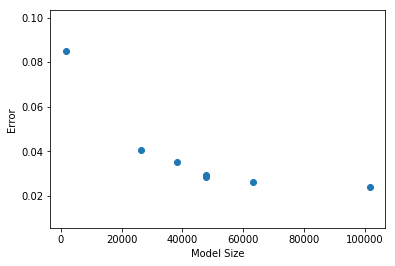

In [9]:
import numpy as np
import matplotlib.pyplot as plt

mean_02 = 0.9761666666666666
mean_03 = 0.9737166666666667
mean_04 = 0.9705999999999999
mean_05 = 0.9716666666666667
mean_06 = 0.9648333333333332
mean_07 = 0.9593166666666665
mean_08 = 0.9150166666666667
size = [1516, 26506, 38170, 47722, 47722, 63370, 101706]
error = [1-mean_08, 1-mean_07, 1-mean_06, 1-mean_05, 1-mean_04, 1-mean_03, 1-mean_02]
plt.scatter(size, error)
plt.xlabel('Model Size')
plt.ylabel('Error')
plt.show()